## 1. Import Packages

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras import layers, models
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201, DenseNet169, DenseNet121
from keras.applications import InceptionV3
from keras.applications import InceptionResNetV2
from keras.applications import Xception
from keras.applications import MobileNetV2
from keras.applications import MobileNet
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import pandas as pd

from sklearn.svm import SVC

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Using TensorFlow backend.


## 2. Data Augmentation

In [3]:
train_path = 'splitted_brain_tumor_dataset/train/'
val_path = 'splitted_brain_tumor_dataset/validation/'

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True)
      
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(150, 150),
                                                   batch_size=1,
                                                   class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_path,
                                                  target_size=(150, 150),
                                                  batch_size=1,
                                                  class_mode='binary')

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## 3. Load the Base Model

In [5]:
# loading base model
IMG_SIZE = (150, 150)
def load_densenet():
    base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,))
    return base_model

In [6]:
model = load_densenet()

In [7]:
def extract_feature(data_gen):
    extracted_feature = []
    features = model.predict_generator(data_gen, steps=len(data_gen))
    
    for feat in features:
        feat = np.array(feat).flatten()
        extracted_feature.append(feat)
    
    extracted_feature = np.array(extracted_feature)
    #features = features.reshape(-1,1)
    return extracted_feature

In [8]:
features_X_train = extract_feature(train_generator)
y_train = train_generator.classes
features_X_test = extract_feature(val_generator)
y_test = val_generator.classes

## 4. Train on ML Models with extracted features

### 4.1 SVM

In [9]:
from sklearn.svm import SVC
classifier_SVM = SVC(kernel = 'rbf', random_state = 0)
classifier_SVM.fit(features_X_train, y_train)

SVC(random_state=0)

In [15]:
train_acc_SVM = classifier_SVM.score(features_X_train, y_train)
test_acc_SVM = classifier_SVM.score(features_X_test, y_test)
print('SVM model accuracy is on train set ', round(train_acc_SVM, 2))
print('SVM model accuracy is on test set ', test_acc_SVM)

SVM model accuracy is on train set  0.67
SVM model accuracy is on test set  0.62


In [16]:
y_pred_SVM = classifier_SVM.predict(features_X_test)

In [17]:
y_pred_SVM

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [18]:
from sklearn import metrics
def print_performance_metrics(test_labels,predict):
    print('Accuracy:', np.round(metrics.accuracy_score(test_labels, predict),4))
    print('ROC Area:', np.round(metrics.roc_auc_score(test_labels, predict),4))
    print('Precision:', np.round(metrics.precision_score(test_labels, predict,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(test_labels, predict,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(test_labels, predict,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(test_labels, predict),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(test_labels, predict),4)) 
    print('\t\tClassification Report:\n', metrics.classification_report(test_labels, predict))

print_performance_metrics(y_test,y_pred_SVM)

Accuracy: 0.62
ROC Area: 0.5
Precision: 0.3844
Recall: 0.62
F1 Score: 0.4746
Cohen Kappa Score: 0.0
Matthews Corrcoef: 0.0
		Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.62      1.00      0.77        31

    accuracy                           0.62        50
   macro avg       0.31      0.50      0.38        50
weighted avg       0.38      0.62      0.47        50



C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\zeyne

<AxesSubplot:>

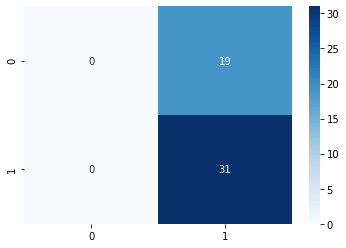

In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred_SVM), 
                cmap='Blues', annot=True)

### 4.2 RANDOM FOREST

In [20]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators = 800, criterion = 'entropy',  random_state = 0)
classifier_RF.fit(features_X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=800, random_state=0)

In [21]:
train_acc_RF = classifier_RF.score(features_X_train, y_train)
print(train_acc_RF)
test_acc_RF = classifier_RF.score(features_X_test, y_test)
print(test_acc_RF)

1.0
0.54


In [22]:
y_pred_RF = classifier_RF.predict(features_X_test)
print_performance_metrics(y_test,y_pred_RF)

Accuracy: 0.54
ROC Area: 0.466
Precision: 0.486
Recall: 0.54
F1 Score: 0.4978
Cohen Kappa Score: -0.0748
Matthews Corrcoef: -0.0824
		Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.16      0.21        19
           1       0.60      0.77      0.68        31

    accuracy                           0.54        50
   macro avg       0.45      0.47      0.44        50
weighted avg       0.49      0.54      0.50        50



<AxesSubplot:>

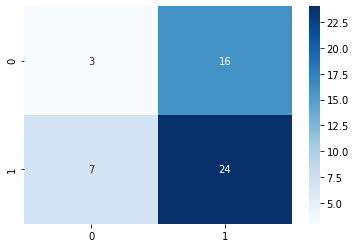

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred_RF), 
                cmap='Blues', annot=True)

### 4.3 ADABOOST

In [25]:
from sklearn.ensemble import AdaBoostClassifier
classifier_AB = AdaBoostClassifier(n_estimators = 100)
classifier_AB.fit(features_X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [28]:
train_acc_AB = classifier_AB.score(features_X_train, y_train)
print(train_acc_AB)
test_acc_AB = classifier_AB.score(features_X_test, y_test)
print(test_acc_AB)

1.0
0.54


In [29]:
y_pred_AB = classifier_AB.predict(features_X_test)
print_performance_metrics(y_test,y_pred_AB)

Accuracy: 0.54
ROC Area: 0.517
Precision: 0.5447
Recall: 0.54
F1 Score: 0.5421
Cohen Kappa Score: 0.0336
Matthews Corrcoef: 0.0336
		Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.42      0.41        19
           1       0.63      0.61      0.62        31

    accuracy                           0.54        50
   macro avg       0.52      0.52      0.52        50
weighted avg       0.54      0.54      0.54        50



<AxesSubplot:>

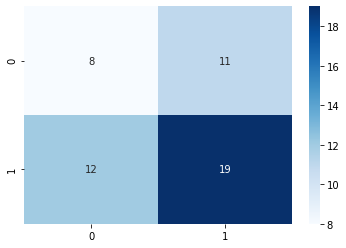

In [30]:
sns.heatmap(confusion_matrix(y_test, y_pred_AB), 
                cmap='Blues', annot=True)

### 4.4 KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kNN = KNeighborsClassifier(n_neighbors = 5, algorithm='ball_tree', leaf_size=30)
classifier_kNN.fit(features_X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree')

In [34]:
train_acc_kNN = classifier_kNN.score(features_X_train, y_train)
print(round(train_acc_kNN,2))
test_acc_kNN = classifier_kNN.score(features_X_test, y_test)
print(test_acc_kNN)

0.69
0.58


In [35]:
y_pred_kNN = classifier_kNN.predict(features_X_test)
print_performance_metrics(y_test,y_pred_kNN)

Accuracy: 0.58
ROC Area: 0.5594
Precision: 0.5843
Recall: 0.58
F1 Score: 0.5819
Cohen Kappa Score: 0.1176
Matthews Corrcoef: 0.1178
		Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.47      0.46        19
           1       0.67      0.65      0.66        31

    accuracy                           0.58        50
   macro avg       0.56      0.56      0.56        50
weighted avg       0.58      0.58      0.58        50



<AxesSubplot:>

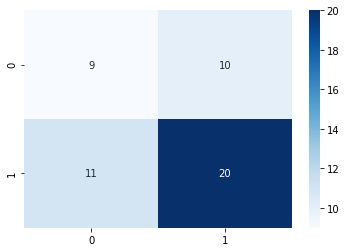

In [36]:
sns.heatmap(confusion_matrix(y_test, y_pred_kNN), 
                cmap='Blues', annot=True)

### 4.5 XGBOOST

In [37]:
import xgboost as xgb
classifier_xgb = xgb.XGBClassifier(n_estimators = 300)
classifier_xgb.fit(features_X_train, y_train)

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[10:49:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
train_acc_xgb = classifier_xgb.score(features_X_train, y_train)
print(train_acc_xgb)
test_acc_xgb = classifier_xgb.score(features_X_test, y_test)
print(test_acc_xgb)

1.0
0.48


In [39]:
y_pred_xgb = classifier_xgb.predict(features_X_test)
print_performance_metrics(y_test,y_pred_xgb)

Accuracy: 0.48
ROC Area: 0.4482
Precision: 0.48
Recall: 0.48
F1 Score: 0.48
Cohen Kappa Score: -0.1036
Matthews Corrcoef: -0.1036
		Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.32      0.32        19
           1       0.58      0.58      0.58        31

    accuracy                           0.48        50
   macro avg       0.45      0.45      0.45        50
weighted avg       0.48      0.48      0.48        50



<AxesSubplot:>

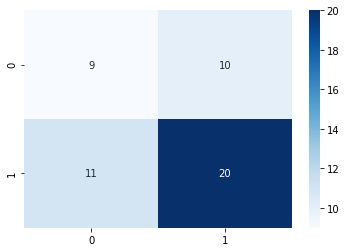

In [40]:
sns.heatmap(confusion_matrix(y_test, y_pred_kNN), 
                cmap='Blues', annot=True)